## Semester 1 Project Submission

Please fill out:
* Student name: Mason Batchelor, Jessica Pasqeusi, Maninder Bawa, Vijeet Yarlagadda
* Instructor name: Lera Tsayukova, Charlie Rice, Joe Comeaux

In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
### Relevant Imports ###
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import math
import os

sns.set_palette("pastel")
%matplotlib inline

# Overview

Our group has been tasked with analyzing historical data from multiple sources regarding information about different movie productions. Our goal is to come up with three recommendations for the company Computing Vision in order to enter into the Movie Industry. Computing vision is a company that has seen the growth of companies creating video content and wanted to get in on the action however, they aren't sure of the best market entry strategy. We are going to define what success looks like in the movie indsutry but more specifically for this firm.


# Business Understanding

### Business Understanding

Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

Key Business Questions: 
* What is success?
    * How much the movie grosses from “The Numbers”
    * The averaging rating / number of votes from IMDB database
    * Total Profit and Gross Margin based on budget size
* What do successful movies look like given our metrics
* How does genre impact the success of a movie (Based on Financial Metrics?
* Does director impact the rating and the net profitability?
* What time of the year (month) is best to release a movie?

### What is Success?
We will define success in two ways. The first being the Gross Margin and the other being Total Profit. The Gross Margin calculations are detailed below. The reason we chose to focus on profitabilty metrics instead of ratings was because this company, computing vision, is trying to break into a well established market they want to ensure that the investment they put in is having a positive return. 


### Business Metrics

Our recommendations for this company will be based off of the Gross Margin which is portrayed as a percentage. The higher this percentage is the more the company is retaining for every dollar that is invested in the movie and as such is seeing a higher return on their investment. This is not necessarily equivalent to a standard ratio of Gross Margin which would include Net Sales and COGS however, considering the "Gross" columns of our data frame as a proxy for sales, and Production Budget as a proxy for COGS will yield similar results and actionable outcomes

$Gross Margin = \frac{Gross Revenue - Production Budget}{Gross Revenue} x 100$

This is an important metric, especially for a company about to enter an industry they have no presence in because it will help show how far their money goes to create profit. The higher this percentage the better the business will be doing because it is an indicator that retains more on each dollar of sales to its costs. This metric also allows us to take a standardized approach to comparing movies and their success. 

We want to investigate what a "Good Movie" i.e. a movie with a high Gross Margin is doing and try to emulate that. Thus we will explore the budget size, what directors are involved in those high margin films, and also what genres see the highest margin

# Data Understanding

The data we chose to focus most of our efforts on came from:
* IMDB
* The Numbers
* TheMovieDB

Where most of our recommendations came from The Numbers which contains the Gross Revenue and Production Budget numbers as well as IMDB and TheMoviesDB which contained a lot of background information on the movies including ratings and genre.


### Opening all zipped files and databases

We began our exploring our data by unzipping the SQLite database as well as reading in all of out csv/tsv files into pandas data frames to get a better idea of how we can approach cleaning the data

In [3]:
# open an sqlite connection

conn = sqlite3.connect("zippedData/im.db")
cur = conn.cursor()

In [4]:
# Pull all of the tables in the database
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [5]:
# query the notable tables movie_basics
q1 = """
SELECT *
FROM movie_basics
LIMIT 5;
"""
pd.read_sql(q1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [6]:
# query the notable tables movie_ratings
q2 = """
SELECT *
FROM movie_ratings
LIMIT 5;
"""
pd.read_sql(q2, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


#### IMDB Database information

These two database tables share a "movie_id" column, thus we can join on this key and take a look at movie information including name, release year, and genre as well as the average rating with the number of votes. We want to find a good balance of average rating as well as number of ratings since a small number of really high ratings could skew the interpretation of what a "good" movie is.

### CSV and TSV file information

Read in all of the tsv and csv files in the proper formatting ensuring headers and proper indexing for the ones which require it as well as proper encoding for the tsv files

In [7]:
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv",header = 0, sep = '\t')    

reviews = pd.read_csv("zippedData/rt.reviews.tsv", header = 0, sep = '\t', encoding= 'unicode_escape')

tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv", header = 0)    

movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", header = 0)

movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv", header = 0)

#### Rotten Tomatoes Movie Info Dataframe

This dataframe contains general information regarding the movies including rating, director, release date for theaters and DVD as well as the currency, box office, runtime and studio. There is a unique id column which we will not use as an index because it could be useful for combining data frames or doing different lookups

We may consider dropping currency, box office, and studio due to there being many missing values

Most columns are missing values and as such we will have to fill or deal with those missing values accordingly, this dataframe is related to the reviews data frame by the id column which relates to a unique id for each movie

In [8]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [9]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


#### Rotten Tomatoes Review Dataframe

The most important information from this dataframe will be the id which cooresponds to the movie that they are reviewing and the rating that they give it. We are missing about more than 10,000 ratings which is a considerable amount to discard, so we could fill these with the average value of the rating for the movie that they are reviewing. In order to make thge rating a useful variable we would have to apply a function to transform it from a string into a float rating value

A more advanced approach would be to conduct sentiment analysis and apply weights to the most common keywords found in a review at each score level and develop a heuristic to apply a score to the missing values based on the review that they left discarding all review entries without an actual review.

This data frame has a relation to the movie_info data frame since bothg come from rotten tomatoes. The id relates to the movie that each critic leaves a review for. 

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [11]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [12]:
reviews['rating'].value_counts()

3/5       4327
4/5       3672
3/4       3577
2/5       3160
2/4       2712
          ... 
2.6/6        1
2.3/4        1
4.3/10       1
5.2          1
T            1
Name: rating, Length: 186, dtype: int64

In [13]:
reviews['rating'].value_counts()

3/5       4327
4/5       3672
3/4       3577
2/5       3160
2/4       2712
          ... 
2.6/6        1
2.3/4        1
4.3/10       1
5.2          1
T            1
Name: rating, Length: 186, dtype: int64

#### The Movie DB Dataframe

This dataframe is not missing any values. It has information about genre ids and contains a unique id column along with the movie name, how many votes it received, and what the average vote value was. Vote seems to be this specific sites way of ranking the movies. 

In [14]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [15]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [16]:
# Create a dictionary to relate the genre id's to the genre found on the movie DB website at 
# this customer support url: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
tmbd_genres = {28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime", 99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"}

#### The Numbers Movie Budgets Data Frame

This data frame is also not missing any values, it contains an ID for each movie, the title, production budget, how much the movie grossed domestically and how much it grossed worldwide

We will be transforming this data by making the budget and gross column integers as well as adding additional columns for profit and Gross Margin to help us in later analysis

In [17]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [18]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


#### Box Office Mojo Movie Gross Data Frame

This data frame is missing a lot of foreign gross values which could potentially be filled in by taking the difference from the budgets df ww_gross - domestic_gross, otherwise we will throw out those values because we can not estimate them.

An alternative that we will not explore is scraping the web with the name of the movie and pulling in the foreign gross numbers. We are missing a few domestic gross numbers which can be thrown away since there are not many of them or we can use the movie budgets dataframe again to fill those in. 

We most likely will not use this data frame because the movie_budgets dataframe offer the same information and a bit more that is helpful to our analysis

In [19]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [20]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


# Data Preparation

### Data Cleaning for movie_budgets DataFrame

The money_clean function we created removes the '$' and comma symbols from the input string. We used this function to clean the production_budget, domestic_gross, and worldwide_gross columns.

In [21]:
# This is the column of budgets which we want to investigate - notice formatting problems
prod_budget = movie_budgets["production_budget"]
prod_budget

0       $425,000,000
1       $410,600,000
2       $350,000,000
3       $330,600,000
4       $317,000,000
            ...     
5777          $7,000
5778          $6,000
5779          $5,000
5780          $1,400
5781          $1,100
Name: production_budget, Length: 5782, dtype: object

In [22]:
def money_clean(s):
    ''' 
    Takes in a string s, removes first character ($) and
    all commas return the value cast as an int
    '''
    s = s[1:]
    s = s.replace(",", "")
    return int(s)

# apply the method to the pandas series of budget values
prod_budget = prod_budget.apply(money_clean)

In [23]:
# Set this cleaned series to the budget column in the data frame
movie_budgets["production_budget"] = prod_budget

# apply the function to the other money columns
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].apply(money_clean)
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].apply(money_clean)

# Calculate new values for foreign gross 
movie_budgets["foreign_gross"] = movie_budgets["worldwide_gross"] - movie_budgets["domestic_gross"]

# calculate the profit by taking gross minus budget (Revenue - cost)
movie_budgets["domestic_profit"] = movie_budgets["domestic_gross"] - movie_budgets["production_budget"]
movie_budgets["foreign_profit"] = movie_budgets["foreign_gross"] - movie_budgets["production_budget"]
movie_budgets["total_profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]

In [24]:
# create new month and year columns for later analysis
rel_date = movie_budgets["release_date"].str.strip()

month = rel_date.apply(lambda x : x[:3])
year = rel_date.apply(lambda x : x[-4:])

movie_budgets["month"] = month
movie_budgets["year"] = year

In [25]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2015837654,335507625,1590837654,2351345279,Dec,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,804600000,-169536125,394000000,635063875,May,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,107000000,-307237650,-243000000,-200237650,Jun,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,944008095,128405868,613408095,1072413963,May,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,303181382,379540365,999721747,Dec,2017


# Exploratory Data Analysis and Visualization

## Mason Batchelor

##### Mason works only in this section and makes No changes to any other



### Analyzing Movie Budgets

Within the movie budgets data frame we created new column to represent the profit, month, and year for each of the entries. We are going to look at the relationship between many of these variables below. 

Adding in a Gross Margin column is essential given this is the metric we are most interested in. We will use this first to analyze the differnce in budgets, and recommend whether the company should target a large or small budget film. We are going to be taking a sample of 100 movies from the movie_budgets data frame to help with our analysis and visualizations. 

Additional Assumptions:
- only consider movies with a Gross value (worldwide, domestic, and foreign) greater than zero because you cannot calculate Gross Margin with 0 gross revenue
- random samples from this data frame are representative of the population, and will be used in a independent two sample ttest
- only consider within 1.5 times the IQR range on both sides to remove outliers
- Do this independently for each of the categories domestic, foreign, and worldwide to get more accurate results

##### Determine Budget Size Categories
Through research we found the following:
- Less than \\$10,000,000 is considered small budget
- Between \\$10,000,000 and \\$50,000,000 is considered medium budget
- greater than \$50,000,000 is considered big budget

Based on our research we found that there was a lot of "gray area" in the middle of small and large budget movies. We adjusted our valuations for these based on Computing Vision's ideal budget. This allowed us to look at a more even amount of values in each category to get a better assessment of the bins we created.

##### Filter Gross Margins

Creating a Budget Size categorical variable to be used for visualizing the gross margins will be crucial. Below, we are working on creating mutliple visualizations for the gross margins for worldwide, domestic, and foreign. In order to properly ignore outliers we are ignoring  everything that is outside 1.5*IQR and this is because this company wants to know what will help them be most successful. By avoiding outliers at the top and bottom ends of the extremes we can more clearly see how most films perform

In [26]:
sns.set_style("darkgrid")

In [27]:
dates = pd.to_datetime(movie_budgets['release_date'])
months = dates.dt.month
movie_budgets['month_index'] = months

In [28]:
def budget_size(val): 
    ''' This function takes in a budget int value and returns a category'''
    small_num = 10000000
    large_num = 50000000
    if val < small_num:
        return 1
    elif val < large_num:
        return 2
    else:
        return 3

In [29]:
# Create the Gross Margin column in a new dataframe called budgets
budgets =  movie_budgets.copy(deep = True)

# only use movies that gross > 0 (denominator cannot be 0)
budgets = budgets.loc[budgets['worldwide_gross'] > 0]
budgets['budget_size'] = budgets['production_budget'].apply(budget_size)
# calculate gross Margin
budgets['gross_margin_ww'] = (budgets['worldwide_gross'] - 
budgets['production_budget']) / budgets['worldwide_gross'] * 100
# Create budget size categorical variable to analyze differences between them
# filtered_budgets.loc[:, 'budget_size'] = filtered_budgets.loc[:, 'production_budget'].apply(budget_size)

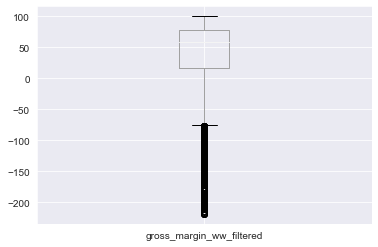

In [30]:
# REMOVE OUTLIERS from data frame
Q1 = budgets['gross_margin_ww'].quantile(.25)
Q3 = budgets['gross_margin_ww'].quantile(.75)
IQR = Q3 - Q1

# query out the outliers in the budgets data frame which are 1.5 x the iqr
statement = ((budgets['gross_margin_ww'] >= (Q1 - 1.5 * IQR)) & 
            (budgets['gross_margin_ww'] <= (Q3 + 1.5*IQR)))

filtered_budgets = budgets.loc[statement]
# Ploting the result to check the difference 
budgets.join(filtered_budgets, rsuffix='_filtered').boxplot(['gross_margin_ww_filtered']);

#### Recap
We have all of the movies gross margin, and have removed any outliers that may skew the data related to budget. We have a value of 1, 2, or 3 to each of the movies indicating whether or not they are small, medium, or big budget films. We can move on with our analysis now to look at relationships between gross margin and the rest of the factors

### Relationship Between Ratings and Financial Variables

Below we wanted to explore the relationship between ratings and movie production budgets, total profit, and worldwide gross marign. The findings were rather inconclusive as many data values are lost trying to relate the imdb database and the budgets dataframe due to a lack of common relation. We attempted to merge using the movie title however that did not offer nearly as many rows as we would have liked. 

The relationships can be described as follows:
- 

In [31]:
q1 = """
SELECT *
FROM movie_basics
Limit 5;
"""
pd.read_sql(q1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [32]:
q2 = """
SELECT *
FROM movie_ratings
Limit 5;
"""
pd.read_sql(q2, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [33]:
q3 = """
SELECT movie_id, primary_title as title, averagerating, numvotes 
FROM movie_basics as b
    JOIN movie_ratings as r
        USING (movie_id);
"""

df = pd.read_sql(q3, conn)

In [34]:
df2 = filtered_budgets.merge(df, left_on='movie', right_on='title', how = 'inner')

In [35]:
df2.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year,month_index,budget_size,gross_margin_ww,movie_id,title,averagerating,numvotes
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2015837654,335507625,1590837654,2351345279,Dec,2009,12,3,84.692106,tt1775309,Avatar,6.1,43


#### Production Budget and Average Rating

There is a weak but positive relationship between these two variables. This is indicative that a high budegt movie does not necessaryily yield high ratings and in fact some of the highest rated movies are on the lower end of the spectrum. This shows up that rating does not necessarily relate very strongly to a companies investment. 

,production_budget,averagerating
production_budget,1.000000,0.091023
averagerating,0.091023,1.000000


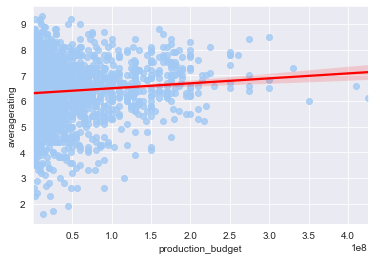

In [73]:
sns.regplot(data = df2, x = 'production_budget', y = 'averagerating', line_kws={"color": "red"})
df2[['production_budget', 'averagerating']].corr()

#### Total Profit and Average Rating

There is a weak, positive correlation between the average rating of a movie and the total profit. As the average rating goes up, we would expect a slight trend upward in the total profit however this relationship is not very strong and average rating does not seem to be the best metric for determining financial success which would be important to Computing Vision

,total_profit,averagerating
total_profit,1.000000,0.143146
averagerating,0.143146,1.000000


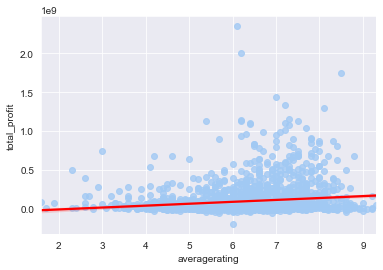

In [74]:
sns.regplot(data = df2, x = 'averagerating', y = 'total_profit', line_kws={"color": "red"})
df2[['total_profit', 'averagerating']].corr()

#### Gross Margin Worldwide and Average Rating

Our metric of Gross Margin compared to average rating shows a weak relationship with a wide spread of data that does not give measurable insights. We believe that average rating is not a good indicator of success and as such we will focus our efforts on financial metrics to determine what success is.

,gross_margin_ww,averagerating
gross_margin_ww,1.000000,0.042554
averagerating,0.042554,1.000000


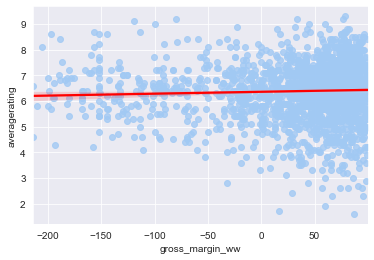

In [75]:
sns.regplot(data = df2, x = 'gross_margin_ww', y = 'averagerating', line_kws={"color": "red"})
df2[['gross_margin_ww', 'averagerating']].corr()

#### Gross Margin Worldwide and Total Profit

As we can see, our metric is a stronger indicator of total profit than average rating. While it is not necessarily strong, it would seem that tjhis graph is exponential in nature and a different metric of comparison may be better suited. For us, the correlation coefficient of 0.36 was sufficient to continue our analyses

,gross_margin_ww,total_profit
gross_margin_ww,1.000000,0.358829
total_profit,0.358829,1.000000


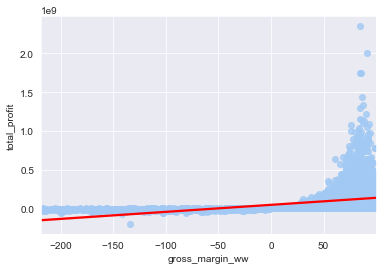

In [76]:
sns.regplot(data=filtered_budgets, x='gross_margin_ww', y='total_profit', line_kws={"color": "red"})
filtered_budgets[['gross_margin_ww', 'total_profit']].corr()

#### Production Budget and Total Profit

We see there is a moderate borderline strong correlation. This is to be expected however, as we will see later the big budget movies have the highest average total profit however, they are also less likely to be profitable. Fewer big budget films actually turn a profit compared to small budget films. This is good insight to confirms our assumptions that a higher capital investment in a film wield yield a higher magnitude of profits. However, it gets more interesting when looking at the gross margin comparisons of budgets.

,total_profit,production_budget
total_profit,1.000000,0.604971
production_budget,0.604971,1.000000


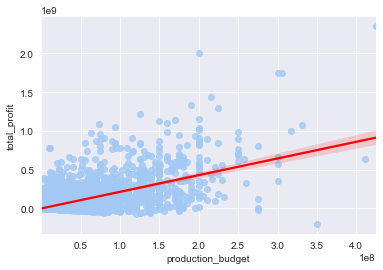

In [77]:
sns.regplot(data=filtered_budgets, x='production_budget', y='total_profit', line_kws={"color": "red"})
filtered_budgets[['total_profit', 'production_budget']].corr()

### Worldwide Gross Margin Visualizations

While looking at the Worldwide gross margin we are looking to see which of the budget size categories would be best to enter into. Worldwide is the initial, holistic view we want to see and this would indicate to us which movie budget size is best suited for turning revenue into profits. 

Below we observe the following:
- Small and Big budget sizes have a higher average gross margin than medium budget
- The total profit follows the expected pattern of small being the lowest and big being the largest
- After a Hypothesis test we observe that at the 90% and 95% confidence levels the small budget movies have a larger mean gross margin than big budget films

Based on the results of this hypothesis test we would then want to advise the management of Computing Vision to target a small budget movie because there is a statistically significant difference in the gross margin of small and large

<ipython-input-41-c6111e00634d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}%' for x in vals])


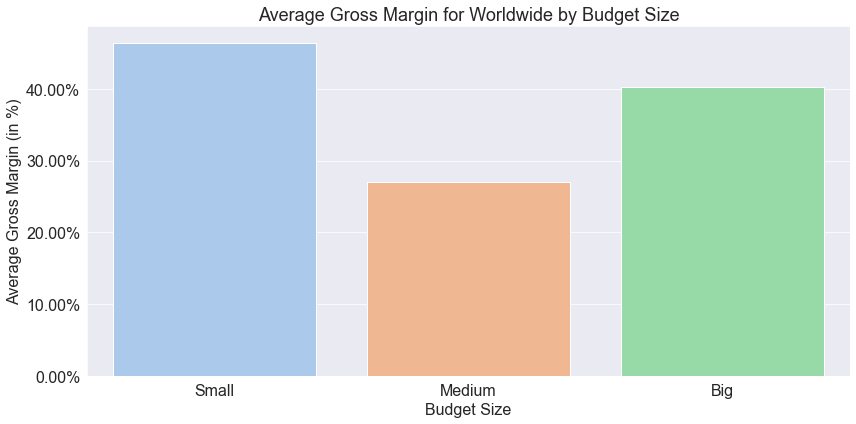

In [41]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)

# Format axis ticks and labels
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title("Average Gross Margin for Worldwide by Budget Size", fontsize = 18)
plt.tight_layout();

# Save as a jpg file
strFile = "visuals/Mean_Gross_Margin_by_Budget_Size.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

<ipython-input-42-0fd2352ef0f9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${x:,.0f}' for x in vals])


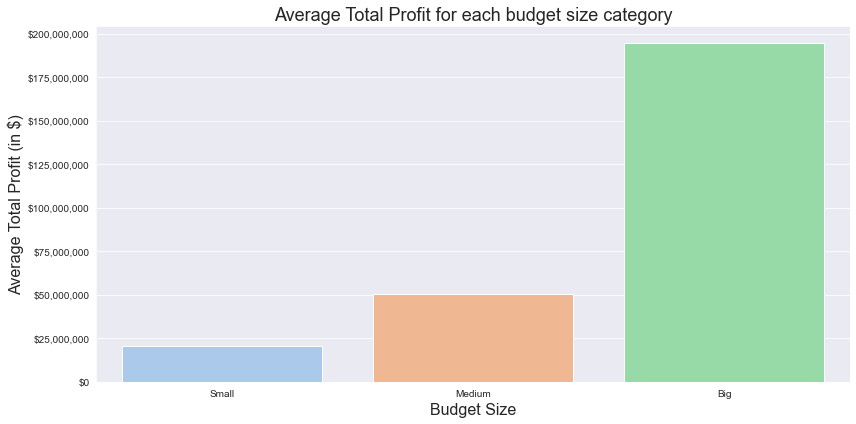

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_profit = filtered_budgets.groupby('budget_size')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit (in $)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])

ax.set_title("Average Total Profit for each budget size category", fontsize = 18)
plt.tight_layout();

# Save as a jpg file
strFile = "visuals/Mean_Total_Profit_by_Budget_Size.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Hypothesis Testing

$H_0:$ There is no difference between small and big budget mean worldwide gross profit margin 

$H_A:$ The mean Worldwide gross profit margins for small budget films is larger than big budget films

We want to use statistical analysis rather than simply a graph because we want to conclude that the mean of both of these samples is the same. We did not analyze every movie to exist and as such we wanted to ensure that our information and the claims that we are making have a statistical backing.

This problem is suited for this analysis because we are observing two seperate groups - the small budget movies and the big budget movies. We are curious if there is a statistically significant difference between their average gross profit margins because we want to be able to make a recommendation to Computing Vision of how much to invest. As we saw above, gross margin correlates weak to moderately with total profit and thus we want to know if the gross margins are different for these two groups.

Limitations: 
* we are not sure what the sample was all we know is that it came from the file provided
* Only considered films with worldwide gross greater than zero (mathematical purposes)
* removed outliers who were 1.5 times the IQR removed from the data. 
* scale of these are drastically different: production budget has a moderate to strong positive correlation with total profit
    * This means regardless a big budget film will net more profit if proftitable
    
Results:
* p-value = 0.00456 < 0.05, < 0.10 thus at both a 90% and 95% confidence level we reject the null hypothesis
* This indicates that we have evidence to support the claim that the mean gross margin for small budget films is larger than big budget films

Statistical Findings:
* The means of the two samples are significantly different
* the mean gross profit margin for small budget films is larger than that of big budget films 
* Note that the scale of these are drastically different

##### Statistical Recommendation
For a company such as Computing Vision making their first break into the film industry, beginning with a low budget film that has the potential to turn a high percentage of gross revenue into profits can be a great start which they can then scale up and produce bigger budget films as they become a better known name in the industry

Produce a Small Budget Film
    
    * Small Budget Films have an average Gross Margin of 46.41% and Big Budgets is 40.33%
    * These results are significantly different based on our testing and as such we would recommend Small Budgett
    * Thus a better chance to see return on money spent producing a film since the average gross margin is larger

In [43]:
budget_size_means = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()
budget_size_stds = filtered_budgets.groupby('budget_size')['gross_margin_ww'].std()
budget_size_val_cnts = filtered_budgets.groupby('budget_size')['gross_margin_ww'].count()

mean1 = budget_size_means[1]
std1 = budget_size_stds[1]
nobs1 = budget_size_val_cnts[1]
mean2 = budget_size_means[3]
std2 = budget_size_stds[3]
nobs2 =  budget_size_val_cnts[3]

print(f'Small Budget Mean Gross Margin: {mean1:.4f}')
print(f'Big Budget Mean Gross Margin:   {mean2:.4f}\n')
# hyopothesis test for the mean gross margin of small and big budget films
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)
print(f'''P Value: {results.pvalue/2} < .05 thus we reject the null hypothesis, evidence supports that 
          the average gross margin is larger for the small and big budget films''')

Small Budget Mean Gross Margin: 46.4061
Big Budget Mean Gross Margin:   40.3315

P Value: 0.004564820511772504 < .05 thus we reject the null hypothesis, evidence supports that 
          the average gross margin is larger for the small and big budget films


### Observations of Outliers

We want to observe the outlier to get a better sence of what the data is showing that we are removing.

In [44]:
Q1 = budgets['gross_margin_ww'].quantile(.25)
Q3 = budgets['gross_margin_ww'].quantile(.75)
IQR = Q3 - Q1

# query out the outliers in the budgets data frame which are 1.5 x the iqr
statement = ((budgets['gross_margin_ww'] < (Q1 - 1.5 * IQR)) | 
            (budgets['gross_margin_ww'] > (Q3 + 1.5*IQR)))

outliers = budgets.loc[statement]

In [45]:
outliers['gross_margin_ww'].describe()['mean']

-16244.49172313667

In [46]:
outliers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year,month_index,budget_size,gross_margin_ww
193,94,"Mar 11, 2011",Mars Needs Moms,150000000,21392758,39549758,18157000,-128607242,-131843000,-110450242,Mar,2011,3,3,-279.269072
341,42,"Jun 14, 2019",Men in Black: International,110000000,3100000,3100000,0,-106900000,-110000000,-106900000,Jun,2019,6,3,-3448.387097
352,53,"Apr 27, 2001",Town & Country,105000000,6712451,10364769,3652318,-98287549,-101347682,-94635231,Apr,2001,4,3,-913.047179
404,5,"Aug 16, 2002",The Adventures of Pluto Nash,100000000,4411102,7094995,2683893,-95588898,-97316107,-92905005,Aug,2002,8,3,-1309.444263
434,35,"Apr 9, 2004",The Alamo,92000000,22406362,23911362,1505000,-69593638,-90495000,-68088638,Apr,2004,4,3,-284.754327


##### Recap
After observing that the mean of our outliers was so extreme, we thought that it was best to remove these values from the data frame using the standard convention of 1.5 times the IQR. This helped us to observe values that we could create actionable results off of without skewing the data in a way that would cause us to advise improperly. 

It is important to note the existence of these outliers and observe that they are potential examples of what could happen should Computing Vision enter the film industry. By choosing to avoid them, we want to focus on how Computing Vision can be most profitable by mimicing what the films in our sample do. 

### Domestic Gross Margin Visualizations

While looking at the Domestic gross margin we are looking to see which of the budget size categories would be best to enter into. With Domestic, we want to see if there is a specific emphasis between foreign and domestic that the company should have. In other words we want to explore whether they should focus their efforts on Domestic audiences or also Foreign. Our assumptions are the same as above. 

Below we observe the following:
- Small budgets have a higher average Gross Margin for domestic films than both medium and big
- Small budgets are the only positive average value which means on average medium and big budget films lose money domestically

From this we would also want to advise the firm to make a small budget film. Given that the Gross Margin, which represents the ability to convert theater sales into profit given their investment in the project aka their production budget. Having a negative ratio means that they are spending more than the gross revenue coming in which would not lead to a successful film. 

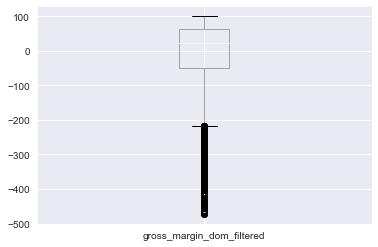

In [47]:
# Create the Gross Margin column in a new dataframe called budgets
dom_copy =  budgets.copy(deep=True)
# only use movies that gross > 0 (denominator cannot be 0)
dom_copy = dom_copy.loc[dom_copy['domestic_gross'] > 0]
# calculate gross Margin
dom_copy['gross_margin_dom']= (dom_copy['domestic_gross'] - 
                              dom_copy['production_budget']) / dom_copy['domestic_gross'] * 100

# REMOVE OUTLIERS from data frame
Q1 = dom_copy['gross_margin_dom'].quantile(.25)
Q3 = dom_copy['gross_margin_dom'].quantile(.75)
IQR = Q3 - Q1
# filter out the outliers in the budgets data frame which are 1.5 x the iqr
# filtered_copy = copy.query('(@Q1 - 1.5 * @IQR) <= gross_margin_dom <= (@Q3 + 1.5 * @IQR)')

statement = ((dom_copy['gross_margin_dom'] >= (Q1 - 1.5 * IQR)) & 
            (dom_copy['gross_margin_dom'] <= (Q3 + 1.5*IQR)))
filtered_dom_copy = dom_copy.loc[statement]

# apply the budget size function to create a new column
# filtered_dom_copy.loc[:, 'budget_size'] = filtered_dom_copy.loc[:, 'production_budget'].apply(budget_size)

# Ploting the result to check the difference 
dom_copy.join(filtered_dom_copy, rsuffix='_filtered').boxplot(['gross_margin_dom_filtered']);

<ipython-input-48-897e2a220806>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}%' for x in vals])


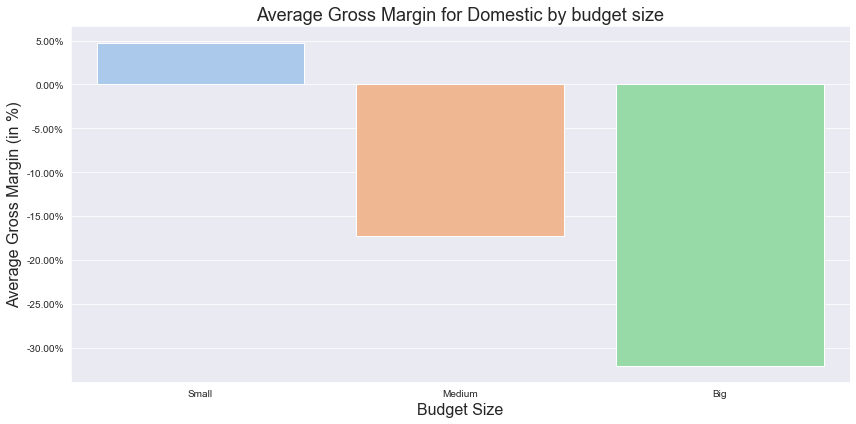

In [48]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_dom_copy.groupby('budget_size')['gross_margin_dom'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Domestic by budget size", fontsize = 18)
plt.tight_layout();

### Foreign Gross Margin Visualizations

While looking at the Foreign gross margin we are looking to see which of the budget size categories would be best to enter into. With Foreign, we want to see if there is a specific emphasis between foreign and domestic that the company should have. In other words we want to explore whether they should focus their efforts on Domestic audiences or also Foreign. Our assumptions are the same as above. 

Below we observe the following:
- Small budgets perform poorly to international audiences whereas big budgets see much greater success
- This is opposite of domestic, thus it will be essential to choose an area to focus on

From this our advise could sway. Big Budget films experience a far larger mean gross margin than small films in foreign markets. This is contrary to what we saw with the worldwide gross margin which makes us more skeptical of these results, the same goes for the domestic gross margin as there must be different outliers impacting both of these. Regardless, we can advise to make a small budget movie and focus on a domestic audience

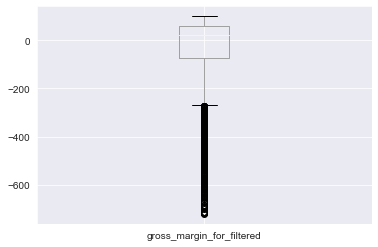

In [49]:
# Create the Gross Margin column in a new dataframe called budgets
for_copy =  budgets.copy(deep=True)
# only use movies that gross > 0 (denominator cannot be 0)
for_copy = for_copy.loc[for_copy['foreign_gross'] > 0]
# calculate gross Margin
for_copy['gross_margin_for']= (for_copy['foreign_gross'] - 
                              for_copy['production_budget']) / for_copy['foreign_gross'] * 100
# REMOVE OUTLIERS from data frame
Q1 = for_copy['gross_margin_for'].quantile(.25)
Q3 = for_copy['gross_margin_for'].quantile(.75)
IQR = Q3 - Q1
# query out the outliers in the budgets data frame which are 1.5 x the iqr
filtered_for_copy = for_copy.query('(@Q1 - 1.5 * @IQR) <= gross_margin_for <= (@Q3 + 1.5 * @IQR)')
# filtered_for_copy.loc[:, 'budget_size'] = filtered_for_copy.loc[:, 'production_budget'].apply(budget_size)

# Ploting the result to check the difference 
for_copy.join(filtered_for_copy, rsuffix='_filtered').boxplot(['gross_margin_for_filtered']);

<ipython-input-50-addb0b96fb19>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}%' for x in vals])


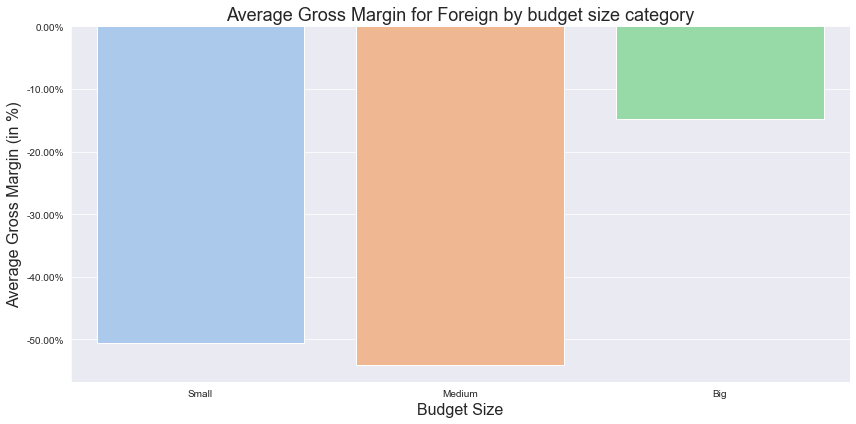

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_for_copy.groupby('budget_size')['gross_margin_for'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Foreign by budget size category", fontsize = 18)
plt.tight_layout();

### Visualizing Random Samples

This was to assist us with our data exploration 

It looks like the gross margin for all gross revenue values is positively correlated which is what we would expect to occur

Production budgets exhibit interesting behavior
* Worldwide there is virtually no relationship based on the trendline
* Domestically as production budget increases, the gross margin trends downwards
* Foreign as production budget increases, the gross margin trends upwards

This leads us to believe that for small budget films they should focus on a domestic audience, and for a large budget film they should focus on their foreign audience

In [51]:
# take a random sample of size 100
sample_ww = filtered_budgets.sample(n=250) # .loc[budgets['gross_margin_ww'] > -100]
sample_dom = filtered_dom_copy.sample(n=250) # .loc[budgets_dom['gross_margin_dom'] > -100]
sample_for = filtered_for_copy.sample(n=250) # .loc[budgets_for['gross_margin_for'] > -100]

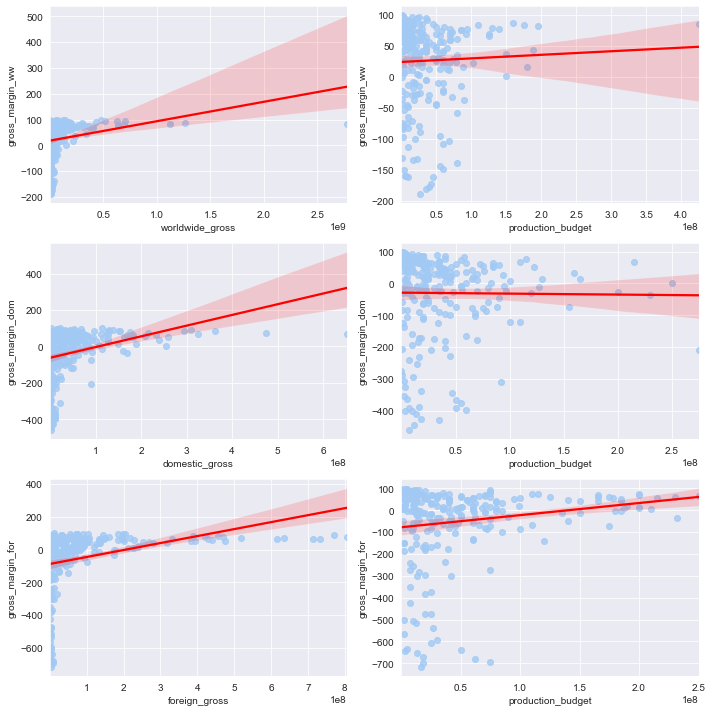

In [66]:
# This plot is visualizing the WORLDWIDE profit margin calculated using worldwide gross
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), ncols = 2, nrows = 3)
sns.regplot(data = sample_ww, x = "worldwide_gross" , y = "gross_margin_ww", ax=ax[0,0], line_kws={"color": "red"});
sns.regplot(data = sample_ww, x = "production_budget" , y = "gross_margin_ww", ax=ax[0,1], line_kws={"color": "red"});

sns.regplot(data = sample_dom, x = "domestic_gross" , y = "gross_margin_dom", ax=ax[1,0], line_kws={"color": "red"});
sns.regplot(data = sample_dom, x = "production_budget" , y = "gross_margin_dom", ax=ax[1,1], line_kws={"color": "red"});

sns.regplot(data = sample_for, x = "foreign_gross" , y = "gross_margin_for", ax=ax[2,0], line_kws={"color": "red"});
sns.regplot(data = sample_for, x = "production_budget" , y = "gross_margin_for", ax=ax[2,1], line_kws={"color": "red"});

#ax1.set_title("Worldwide gross and profit margin (billion)")
#ax2.set_title("Production Budget and profit margin (hundred millions)")
plt.tight_layout();

<ipython-input-67-8ccc778e1ac0>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{x:.2f}%' for x in vals])
<ipython-input-67-8ccc778e1ac0>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f'{x:.2f}%' for x in vals])
<ipython-input-67-8ccc778e1ac0>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'${x:,.0f}' for x in vals])
<ipython-input-67-8ccc778e1ac0>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'${x:,.0f}' for x in vals])


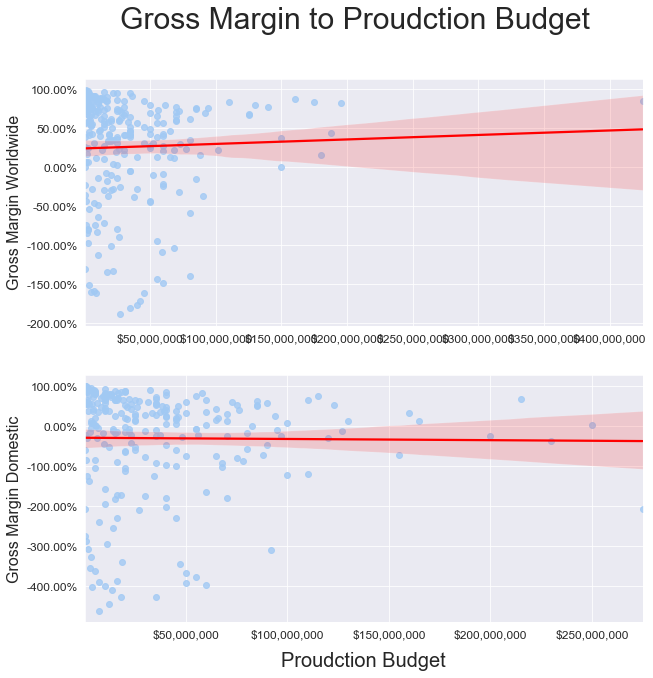

In [67]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

sns.regplot(data = sample_ww, 
            x = "production_budget" , 
            y = "gross_margin_ww", 
            ax=ax[0], 
            line_kws={"color": "red"});
sns.regplot(data = sample_dom, 
            x = "production_budget" , 
            y = "gross_margin_dom", 
            ax=ax[1], 
            line_kws={"color": "red"});

fig.suptitle('Gross Margin to Proudction Budget', fontsize=30)
plt.xlabel('Production Budget', fontsize = 30)

ax[0].set_ylabel("Gross Margin Worldwide", fontsize = 16)
ax[1].set_ylabel("Gross Margin Domestic", fontsize = 16)
ax[0].set_xlabel("", fontsize = 16)
ax[1].set_xlabel("Proudction Budget", fontsize = 20, labelpad=12)

vals = ax[0].get_yticks()
ax[0].set_yticklabels([f'{x:.2f}%' for x in vals])
vals = ax[1].get_yticks()
ax[1].set_yticklabels([f'{x:.2f}%' for x in vals])

vals = ax[0].get_xticks()
ax[0].set_xticklabels([f'${x:,.0f}' for x in vals])
vals = ax[1].get_xticks()
ax[1].set_xticklabels([f'${x:,.0f}' for x in vals])

ax[0].yaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[0].xaxis.set_tick_params(labelsize=12)
ax[1].xaxis.set_tick_params(labelsize=12);

# Save as a jpg file
strFile = "visuals/Scatter_Gross_Margin_by_Production_Budget.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

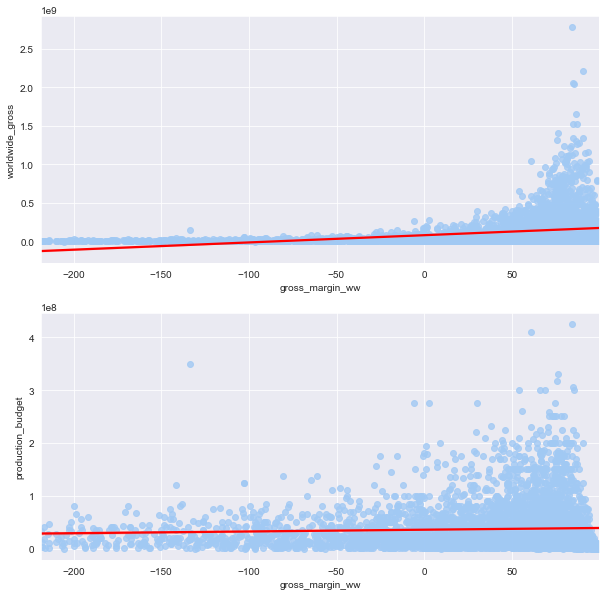

In [68]:
# Visualize the gross margin vs worldwide gross on top and production budget on the bottom graph
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), nrows=2)
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax[0], line_kws={"color": "red"});
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "production_budget", ax=ax[1], line_kws={"color": "red"});

For high budget movies make sure to keep in mind the international audience because as the budget increases profits domestically trend downward however on the international audience profits trend upwards. If you are focusing on a low budget movie to enter into the movie industry then the focus should be domestic because profits tend to be higher comapred to international movies

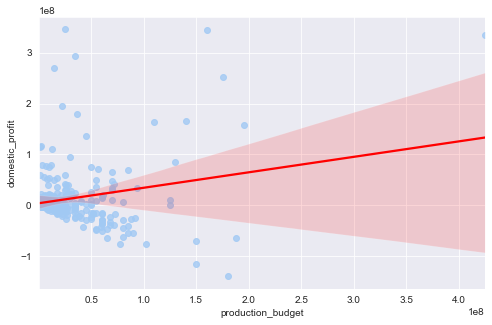

In [69]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "domestic_profit", ax=ax, line_kws={"color": "red"});

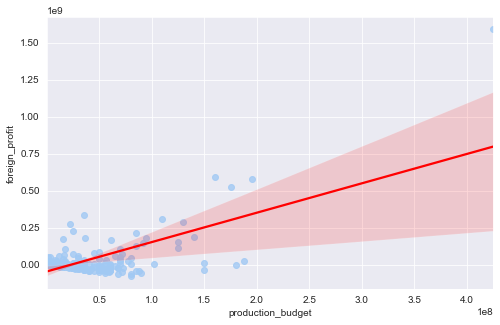

In [70]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "foreign_profit", ax=ax, line_kws={"color": "red"});

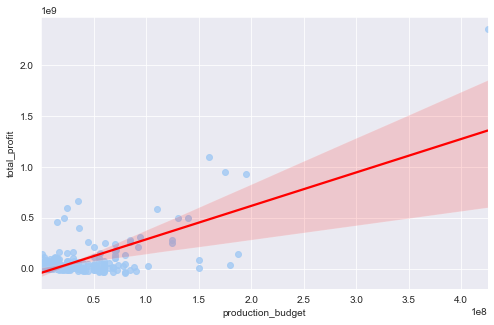

In [72]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "total_profit", ax=ax, line_kws={"color": "red"});

### Visualizing the Gross Margin Across Different Months

Below we see an interesting trend for the Gross Margin which leads us to the following conclusion:

Release your movie in May
    * We see that the summer months, which coincides to when school releases has a spike in average gross margin
        * To be most successful financially, May allows you to capture those months of high revnue
    * There is a dip in Aug, Sept, and Oct however dring the Holidays (Nov and Dec) there is another spike 
        * When releasing in May, you will capture both the summer and holiday high gross margins
        
By releasing in May they have the best chance to capitalize on both peaks of this bimodal bar chart. The summer and winter months tend to see higher gross revenue for films and as such releasing in May offers the best chance for them to capture both and maximize profits. 

As is evidenced by the plot directly below, the average total profits for each month solidify this claim that the most total profit can be seen in May. 

<ipython-input-58-b4cd26f59280>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}%' for x in vals])


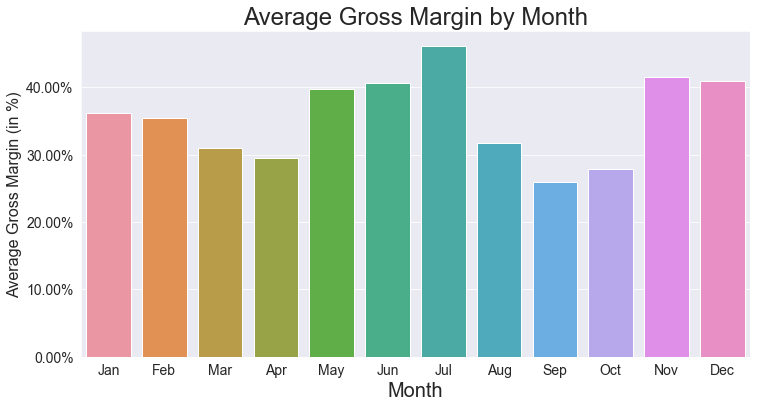

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = filtered_budgets.sort_values('month_index')['month'].unique()
agg_margin = filtered_budgets.groupby('month_index')['gross_margin_ww'].mean()

# plot the data and add labels
sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize = 16)
ax.set_title("Average Gross Margin by Month", fontsize = 24);
ax.set_xlabel("Month", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])


strFile = "visuals/Mean_Gross_Margin_by_Month.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

<ipython-input-59-e3b2493fef09>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${x:,.0f}' for x in vals]);


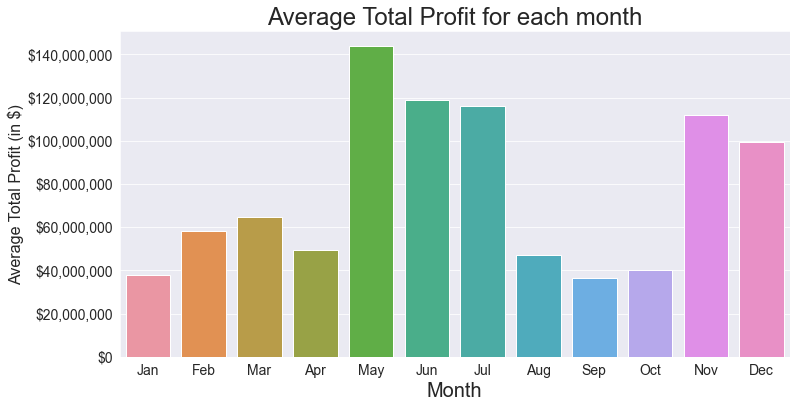

In [59]:
# Plot the total profits over each month 
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = filtered_budgets.sort_values('month_index')['month'].unique()
agg_profit = filtered_budgets.groupby('month_index')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit (in $)", fontsize = 16)
ax.set_title("Average Total Profit for each month", fontsize = 24);
ax.set_xlabel("Month", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals]);

#### Visualizing Total Profit Over Months

These graphs do not have aggregate values and are not being used in the current analysis

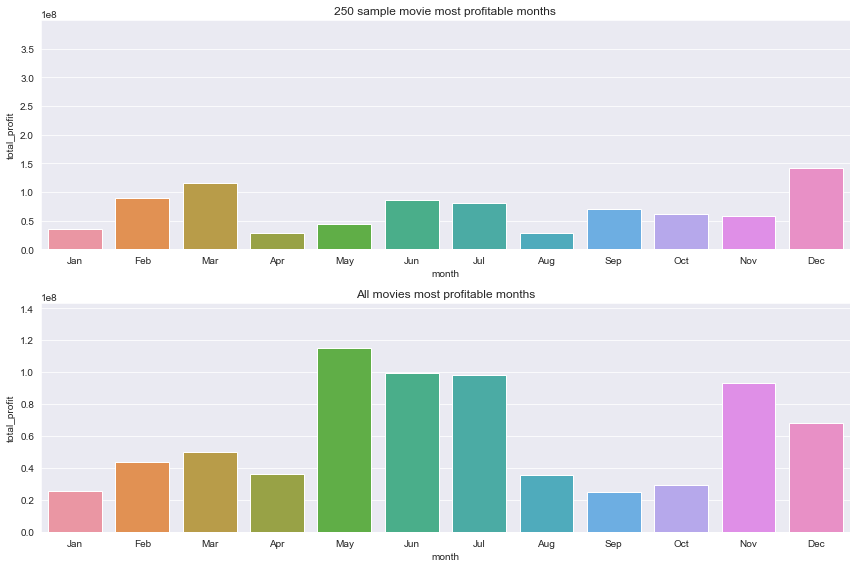

In [60]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,8), nrows = 2)
sns.barplot(data = sample_ww.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax = ax1, 
            errwidth=0)
sns.barplot(data = movie_budgets.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax=ax2, 
            errwidth=0)

ax1.set_title("250 sample movie most profitable months")
ax2.set_title("All movies most profitable months")
plt.tight_layout()

### Checking budget sub categories for small budgets

Dig deeper into the small budgets category to see if we can't decide on a more exact range to recommend. this analysis began much later and as such we would need a little bit more time to be able to fully analyze this information

In [61]:
filtered_budgets.loc[filtered_budgets['production_budget'] < 10000000]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year,month_index,budget_size,gross_margin_ww
3747,48,"Sep 22, 2017",Friend Request,9900000,3759078,11310835,7551757,-6140922,-2348243,1410835,Sep,2017,9,1,12.473305
3749,50,"Apr 3, 2009",Adventureland,9800000,16044025,17553055,1509030,6244025,-8290970,7753055,Apr,2009,4,1,44.169263
3750,51,"Dec 19, 2012",Amour,9700000,6738954,36787044,30048090,-2961046,20348090,27087044,Dec,2012,12,1,73.632021
3751,52,"Apr 28, 2006",The Lost City,9600000,2484186,5256839,2772653,-7115814,-6827347,-4343161,Apr,2006,4,1,-82.619251
3752,53,"Jan 12, 2000",Next Friday,9500000,57176582,59675307,2498725,47676582,-7001275,50175307,Jan,2000,1,1,84.080518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5773,74,"Feb 26, 1993",El Mariachi,7000,2040920,2041928,1008,2033920,-5992,2034928,Feb,1993,2,1,99.657187
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,417166,417760,410166,834926,Oct,2004,10,1,99.168573
5775,76,"May 26, 2006",Cavite,7000,70071,71644,1573,63071,-5427,64644,May,2006,5,1,90.229468
5778,79,"Apr 2, 1999",Following,6000,48482,240495,192013,42482,186013,234495,Apr,1999,4,1,97.505146


In [62]:
# Create quintile bins for the small budget range
bin_labels = ['.2', '.4', '.6', '.8', '1']
copy = filtered_budgets.copy(deep = True)
copy = copy.loc[copy['production_budget'] < 10000000]
copy['small_quintiles'] = pd.qcut(copy['production_budget'], q=5, labels=bin_labels)
sns.barchart()

AttributeError: module 'seaborn' has no attribute 'barchart'

In [ ]:
# Visualize each of the quintile bins and their average gross margin
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = bin_labels
agg_margin = copy.sort_values('small_quintiles').groupby('small_quintiles')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Small Budget Size", fontsize = 16)

# Format axis ticks and labels
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title("Average Gross Margin for Worldwide by Small Budget Buckets", fontsize = 18)
plt.tight_layout();

In [ ]:
budget_size_means = copy.sort_values('small_quintiles').groupby('small_quintiles')['gross_margin_ww'].mean()
budget_size_stds = copy.sort_values('small_quintiles').groupby('small_quintiles')['gross_margin_ww'].std()
budget_size_val_cnts = copy.sort_values('small_quintiles').groupby('small_quintiles')['gross_margin_ww'].count()

In [ ]:
mean1 = budget_size_means['.2']
std1 = budget_size_stds['.2']
nobs1 = budget_size_val_cnts['.2']
mean2 = budget_size_means['.8']
std2 = budget_size_stds['.8']
nobs2 =  budget_size_val_cnts['.8']

print(f'Small Budget Mean Gross Margin: {mean1:.4f}')
print(f'Big Budget Mean Gross Margin:   {mean2:.4f}\n')
# hyopothesis test for the mean gross margin of small and big budget films
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)
print(f'''P Value: {results.pvalue/2} < .05 thus we reject the null hypothesis, 
            evidence supports that the average gross margin is different for 
            the small and big budget films''')

## Maninder Bawa

##### Maninder works only in this section and makes No changes to any other


## Jessica Pasquesi

##### Jessica works only in this section and makes No changes to any other


### Analyzing Movie Genres

Using the filtered movie budgets dataframe that contains Gross Margin columns, we are going to look at the different movie genres in comparison to gross margin and total profit. Gross Margin is the metric that we have been using as a measure of success. We are using this metric, along with total profit, to determine what genre has been most successful. By continuing using the filtered data from above, we are going off of the same assumtpions. To do analysis on the specific genres, we merged the filtered budget dataframe and the TMDB movies data frame that includes information on genres. 

Additional Assumption: 
* When looking at the genre data, we are given multiple genres in one column for a singular movie. We decided to make the assumption that the first genre in the list would be the primary genre and the genre that we will be using to categorize that movie. In this dataframe, there are a few empty values in the genre_ids column. When creating the new genre column, any empty value was named as "No Genre."

In [ ]:
budget_copy = filtered_budgets.copy()
tmdb_budget = pd.merge(tmdb_movies, budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
#tmdb_budgets = pd.merge(tmdb_movies, movie_budgets, left_on = 'title', right_on = 'movie')
#tmdb_budgets.sort_values(by='total_profit', ascending = False)

In [ ]:
# Cleaning up the genre_id column in tmbd_budget dataframe.
tmdb_budget['genre'] = None
index = 0
for row in tmdb_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_budget['genre'][index] = tmbd_genres[key]
    index+=1
                

To justify our assumption that the first genre is the primary genre, we decided to take a random sample of 10 movies from our dataframe and do research on each movie's specific genre.

In [ ]:
tmdb_budget.sample(n=10)

### Visualization of Number of Occurences of Each Genre

In [ ]:
tmdb_budget['genre'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].value_counts().index.tolist()
y_values = tmdb_budget['genre'].value_counts()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
print(tmdb_budget['genre'].value_counts())

From looking at the value counts, we see the Drama Movies are the most common movies in our dataframe. 

### World Wide Gross Margin Visualizations

In [ ]:
#genre vs average total profit
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Gross Margin by Genre", fontsize = 30)
ax.set_ylabel("Worldwide Gross Margin (in %)", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Gross_Margin_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Hypothesis Test 

Hypothesis test to see if the mean gross margin is a good indicator for which movie genre to choose


$H_0:$ There is no difference between Family genre and Mystery genre mean worldwide gross margin 

$H_A:$ The mean Worldwide gross profit margins are different for Family and Mystery Movies

We wanted to see whether we could recommend one genre to be better than the rest, and the results were that based off our samples we fail to reject the null hypothesis and therefore we cannot claim that the mean Gross Margin for Family movies is different than that of mystery movies

In [ ]:
genre_means = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].mean()
genre_stds = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].std()
genre_cnts = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].count()

In [ ]:
mean1 = genre_means['Family']
std1 = genre_stds['Family']
nobs1 = genre_cnts['Family']
mean2 = genre_means['Mystery']
std2 = genre_stds['Mystery']
nobs2 =  genre_cnts['Mystery']


print(f'Family Genre Mean Gross Margin: {mean1:.4f}')
print(f'Mystery Genre Mean Gross Margin:   {mean2:.4f}\n')
# hyopothesis test for the mean gross margin of Drama and Mystery
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)
print(f'''P Value: {results.pvalue} > .05 thus fail to reject the null hypothesis, 
            evidence does not support that the average gross margin is different for 
            the small and big budget films''')
print('\n')
mean3 = genre_means['TV Movie']
std3 = genre_stds['TV Movie']
nobs3 =  genre_cnts['TV Movie']

print(f'Family Genre Mean Gross Margin: {mean1:.4f}')
print(f'TV Movie Genre Mean Gross Margin:   {mean3:.4f}\n')
# hyopothesis test for the mean gross margin of Drama and Mystery
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean3, std3, nobs3)
print(f'''P Value: {results.pvalue} > .05 thus fail to reject the null hypothesis, 
            evidence does not support that the average gross margin is different for 
            the small and big budget films''')

### Gross Domestic Margin Visualization

To analyze the domestic gross margin, we are using the filtered dataframe with the column including domestic gross margin. We are repeating the same process of merging this dataframe with the TMDB movies dataframe that includes genre and creating a new column with the primary genre. 

In [ ]:
dom_budget_copy = filtered_dom_copy.copy()
tmdb_dom_budget = pd.merge(tmdb_movies, dom_budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
# Cleaning up the genre_id column in tmbd_dom_budget dataframe.
tmdb_dom_budget['genre'] = None
index = 0
for row in tmdb_dom_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_dom_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_dom_budget['genre'][index] = tmbd_genres[key]
    index+=1            

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_dom_budget['genre'].unique()
y_values = tmdb_dom_budget.groupby('genre')['gross_margin_dom'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Domestic Gross Margin");

### Gross Foreign Margin Visualization

To analyze the foreign gross margin, we are using the filtered dataframe with the column including foreign gross margin. We are repeating the same process of merging this dataframe with the TMDB movies dataframe that includes genre and creating a new column with the primary genre. 

In [ ]:
for_budget_copy = filtered_for_copy.copy()
tmdb_for_budget = pd.merge(tmdb_movies, for_budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
# Cleaning up the genre_id column in tmbd_for_budget dataframe.
tmdb_for_budget['genre'] = None
index = 0
for row in tmdb_for_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_for_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_for_budget['genre'][index] = tmbd_genres[key]
    index+=1            

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_for_budget['genre'].unique()
y_values = tmdb_for_budget.groupby('genre')['gross_margin_for'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Foreign Gross Margin");

## Analyzing Movie Genres with Profit

After looking at genres with gross margin, we noticed that it did not give very clear results. We decided to also analyze genres with profit. 

### Total Profit Visualizations


In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['total_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Total Profit by Genre", fontsize = 30)
ax.set_ylabel("Total Profit", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);
# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Total_Profit_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Domestic Profit Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['domestic_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Domestic Profit by Genre", fontsize = 30)
ax.set_ylabel("Domestic Profit", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Domestic_Profit_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Foregin Profit Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_for_budget['genre'].unique()
y_values = tmdb_for_budget.groupby('genre')['foreign_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Foreign Profit");

After looking at the different gross margins and total profits in relation to genre, we concluded the producing a genre movie would be the most successful. Genre movies are the most common movie being produced. When looking at 

## Vijeet Yarlagadda

##### Vijeet works only in this section and makes No changes to any other


In [ ]:
genre_df = movie_budgets

genre_df["original_title"] = genre_df["movie"]

genre_df = pd.merge(genre_df, tmdb_movies, on=['original_title'])

budgets["return_on_investment"] = (budgets["total_profit"] / budgets["production_budget"]) * 100

### Probability of Profit

Probability of Profit is a metric used in the financial world to analyze investment risk. The formula to calculate POP is as follows:

$n$ = total number of events

$p_n$ = total number of profitable events

Probability of Profit = $\frac{p_n}{n}$

This can help inform us on how risky making any budget of movie is.


In [ ]:
# Probability of Profit

pop_small = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] < 10000000)]) / len(movie_budgets[movie_budgets["production_budget"] < 10000000])) * 100

pop_md = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] > 10000000) & (movie_budgets["production_budget"] < 50000000)]) / len(movie_budgets[(movie_budgets["production_budget"] > 10000000) & (movie_budgets["production_budget"] < 50000000)])) * 100

pop_big = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] >= 50000000)]) / len(movie_budgets[(movie_budgets["production_budget"] >= 50000000)])) * 100

print("Percentage of Profit for small budget films: ", f'{pop_small : .2f}%' + "%", "\nmedium budget films: ", f'{pop_md : .2f}%' + "%","\nand big budget films: ", f'{pop_big : .2f}%' + "%" )

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])

sns.barplot(x=x_values, y = [pop_small, pop_md, pop_big], errwidth=0)
ax.set_ylabel("Percentage of films that have earned profit")
ax.set_title("Percentage of profiting films by budget size")

#### This graph shows that more large films are profitable than small or medium films.

Next, we'll split the dataset into different datasets within their respective categories.

In [ ]:
small_budget = budgets[budgets["production_budget"] < 10000000]
md_budget = budgets[(budgets["production_budget"] > 10000000) & (budgets["production_budget"] < 50000000)]
big_budget = budgets[(budgets["production_budget"] >= 50000000)]

In [ ]:
def budget_size(val):
    if val < 10000000:
        return 1
    elif val < 50000000:
        return 2
    else:
        return 3
budgets["budget_size"] = budgets["production_budget"].apply(budget_size)

### Return on Investment

Return on Investment is a metric used to find out how profitable a particular financial transaction was.

The formula for ROI is as follows:

ROI = $\frac{Net Profit}{Cost of Investment}$

In [ ]:
budgets.groupby("budget_size")["return_on_investment"].mean()

In [ ]:
budgets['gross_margin_dom'] = (budgets['domestic_gross'] - 
                              budgets['production_budget']) / budgets['domestic_gross'] * 100

budgets_dom = budgets.loc[budgets["domestic_gross"] > 0]

budgets_dom.groupby("budget_size")["gross_margin_dom"].mean()

In [ ]:
budgets_dom.tail()

In [ ]:
budgets['gross_margin_foreign'] = (budgets['foreign_gross'] - 
                              budgets['production_budget']) / budgets['foreign_gross'] * 100

budgets_foreign = budgets.loc[budgets["foreign_gross"] > 0]
budgets_foreign[budgets["gross_margin_foreign"] > -200].groupby("budget_size")["gross_margin_foreign"].mean()


### Grouping by budget size to see them compared by various metrics

In [ ]:
y = budgets.groupby("budget_size")["total_profit"].mean()
fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

#agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total profit by budget size (USD, hundreds of millions)")


In [ ]:
y = budgets_dom.groupby("budget_size")["domestic_profit"].mean()

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

#agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total domestic profit by budget size (USD, hundreds of millions)")

In [ ]:
y = budgets_foreign.groupby("budget_size")["foreign_profit"].mean()

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total foreign profit by budget size (USD, hundreds of millions)")

We can see in the above visualization that the large budget movies tend to perform way better internationally as the foreign audiences may be specially catered to through targeted marketing, dubbing, etc.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()



sns.barplot(x=x_values, y = agg_profit.values, errwidth=0)
ax.set_ylabel("Mean Profit")
ax.set_title("Average gross margin per budget size")

Overall, we see that the different budget sizes perform in different manners that may be able to be explained through the use of the production budget for items such as marketing, etc.